<a href="https://colab.research.google.com/github/AnuR1234/GNN/blob/main/%E2%80%9CAutoencoder_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Task 1

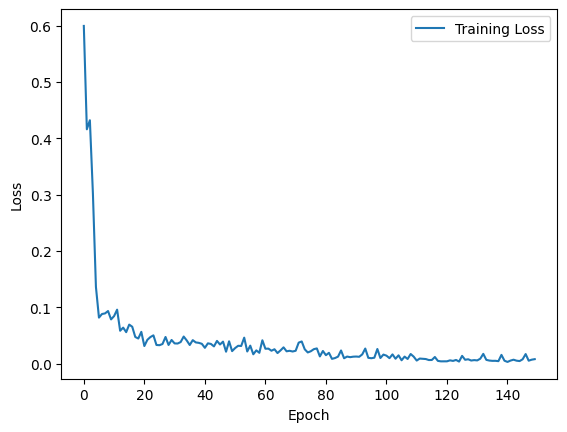

In [ ]:
import torch
from sklearn.datasets import make_moons
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
import os
import matplotlib.pyplot as plt



class autoencoder(nn.Module):
    def __init__(self,input_size,bottleneck_size,hidden_size,layers):
        super(autoencoder, self).__init__()

        encoder_layers = []
        for i in range(layers-1):
            encoder_layers.append(nn.Linear(hidden_size, hidden_size))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(nn.Linear(input_size,hidden_size),nn.ReLU(),*encoder_layers,nn.Linear(hidden_size,bottleneck_size))



        decoder_layers = []
        for i in range(layers-1):
            decoder_layers.append(nn.Linear(hidden_size, hidden_size))
            decoder_layers.append(nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(bottleneck_size,hidden_size),nn.ReLU(),*decoder_layers,nn.Linear(hidden_size,input_size))

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return  encode,decode
    def decode_function(self,code):
        return self.decoder(code)

# Create training set and testing
X, _ = make_moons(n_samples=1000, noise=0.1, random_state=42)
X = torch.FloatTensor(X)


# convert it to tensor
dataset = TensorDataset(X, X)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

#Set parameters
input_size=2
bottleneck_size=1
hidden_size=30
layers=3
model = autoencoder(input_size, bottleneck_size,hidden_size,layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Train
num_epochs = 150
loss_list=[]
state_dicts = {}#Storage parameters
for epoch in range(num_epochs):
    for data in data_loader:
        inputs, _ = data

        # Forward
        _,outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    loss_list.append(loss.item())




# Plot loss
plt.plot(range(num_epochs), loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()







#Comment:
Before we find the best hyperparameters, we just randomly choose hyperparameters to test whether this model works. Then we do the reconstruction and visualize the result.


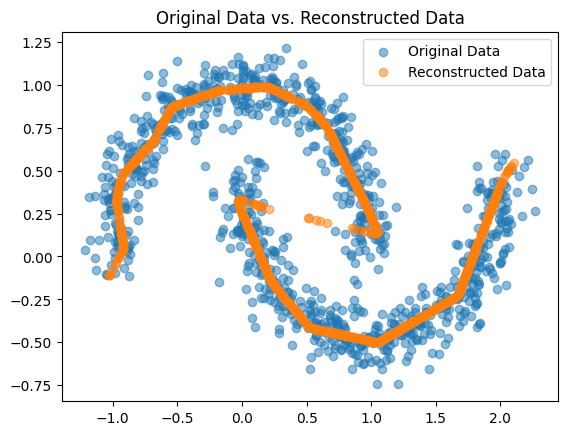

In [ ]:
#reconstruction
with torch.no_grad():

  code,reconstructed_data = model(X)

#Plot
plt.scatter(X[:, 0], X[:, 1], label='Original Data', alpha=0.5)
plt.scatter(reconstructed_data[:,0],reconstructed_data[:,1], label='Reconstructed Data', alpha=0.5)
plt.legend()
plt.title('Original Data vs. Reconstructed Data')
plt.show()



 <div style="color: green; font-weight:
bold">Comment</div>
The code of autoencoder model is basically the same, but they have some procedures which we are lack of. They scale the data and compute the loss on test set.

#1.1 Investigate systematically the effect of the hyperparameters. Report your findings in suitable plots (e.g. test set reconstruction error as a function of hyperparameters, and reconstructed vs. original points for selected settings). Make sure that all plots are properly labeled (title, axis labels, legend). Comment on your findings.

In [ ]:
#Train model with different hidden size and layers
data_size = 500
num_epochs = 50

input_size=2
bottleneck_size=1
hidden_size_list=list(range(10,101,10))
layers_list=list(range(1,11))
Loss = [[] for _ in range(10)]

for layers in layers_list:

  for hidden_size in hidden_size_list:

    model = autoencoder(input_size,bottleneck_size,hidden_size,layers)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    training_set = torch.FloatTensor(X[:data_size,:])
    dataset = TensorDataset(training_set, training_set)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

    Loss_epoch = []
    for epoch in range(num_epochs):
      for data in data_loader:
          inputs,_ = data


          _,outputs = model(inputs)
          loss = criterion(outputs, inputs)


          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      Loss_epoch.append(loss.item())

    Loss[layers-1].append(Loss_epoch)






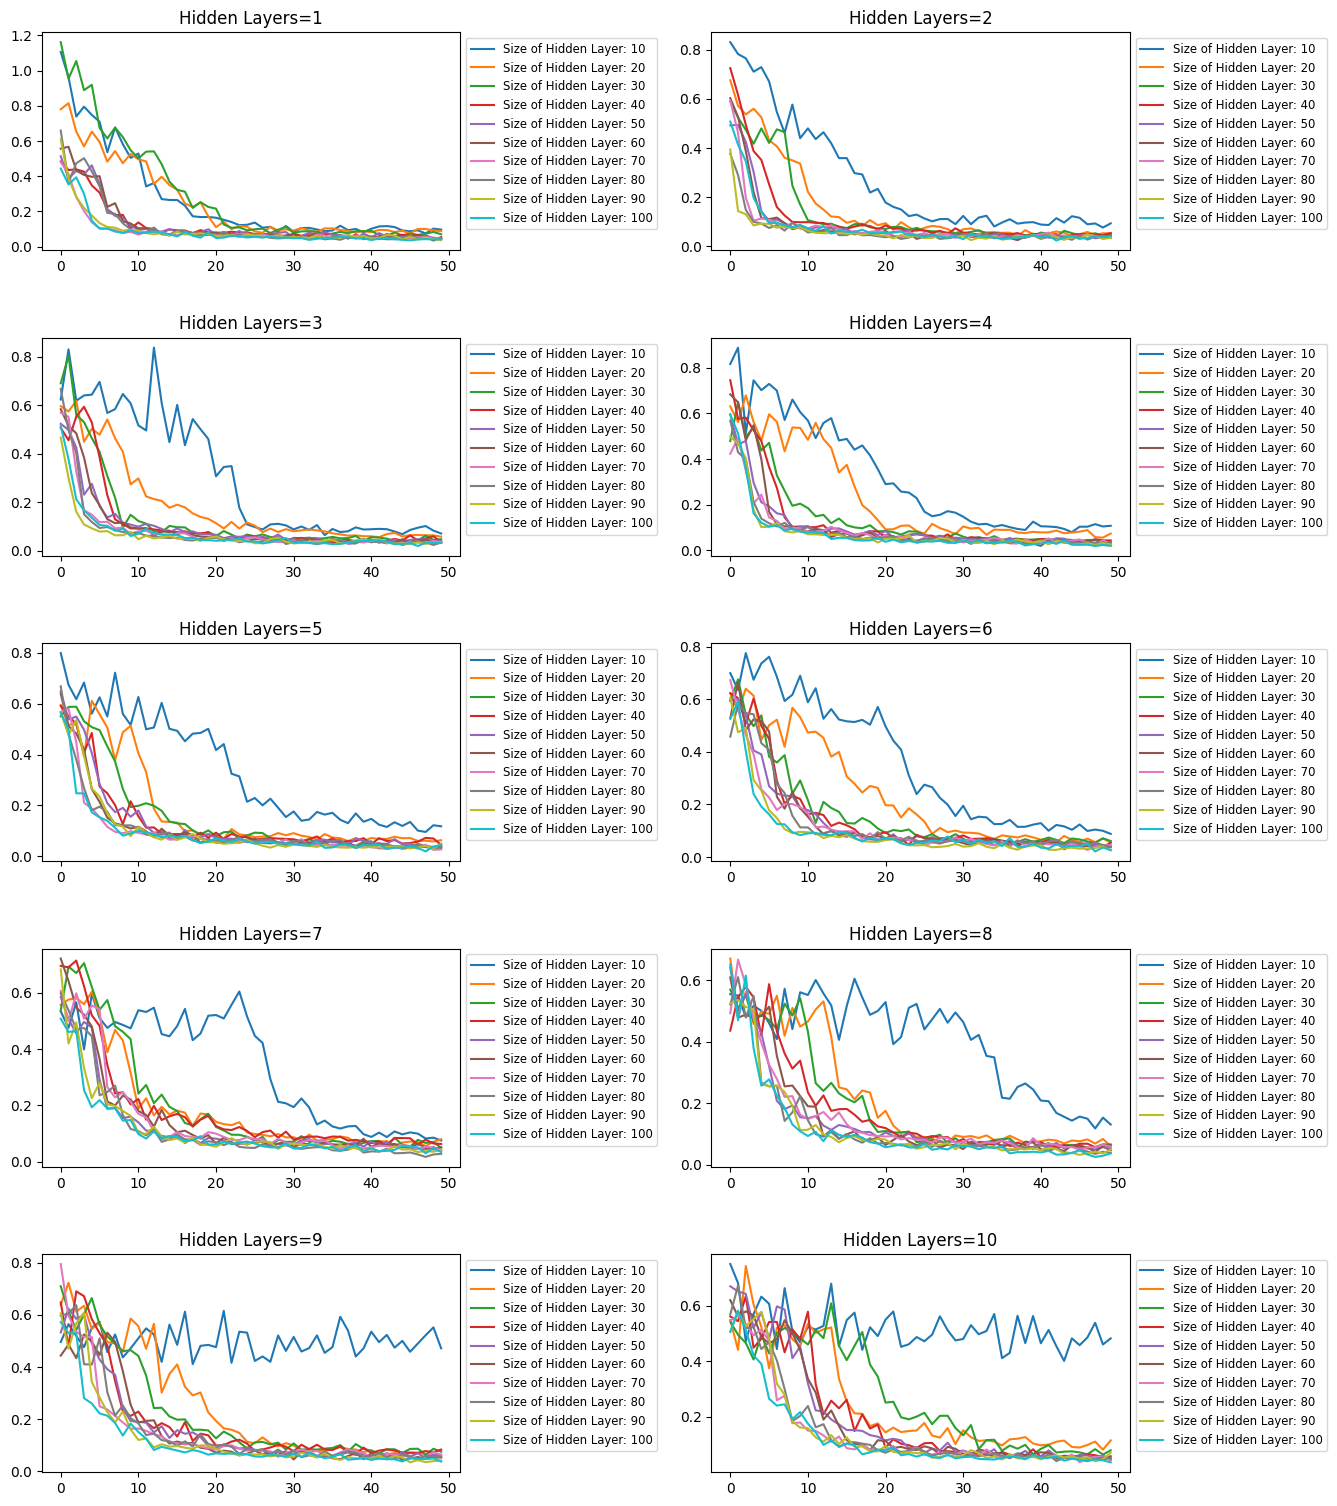

In [ ]:
data_size = 500
num_epochs = 50

input_size=2
bottleneck_size=1
fig, axs = plt.subplots(5, 2,squeeze=False)
for i, ax in enumerate(axs.flat):

    for j, hidden_size in enumerate(hidden_size_list):
      ax.plot(range(num_epochs), Loss[i][j], label=f"Size of Hidden Layer: {hidden_size}")

    ax.legend(fontsize='small', bbox_to_anchor=(1, 1))
    ax.set_title('Hidden Layers='+str(layers_list[i]))


plt.subplots_adjust(left=-0.2, right=1.5, top=3, bottom=0, wspace=0.6, hspace=0.4)


plt.show()

 <div style="color: green; font-weight:
bold">Comment</div>
Here we are different from the example. We consider hidden layers, hidden size and epochs at the same time, and evaluate them by loss instead of visualizing the reconstruction. But the conclusions are same:

1. About the hidden size: the bigger, the better.
2. The increase of  hidden layers wouldn't improve the model performance all the time. We finally chose 5, the same as the worked example.
3. Though the model works good with a small epochs, it still profits from the increase of epochs (when data size=1000). 

#Comment
First, we explored the effect of the number and the size of the hidden layers on the model. We set different sizes of hidden layers in 10 different number of hidden layers respectively. Observing the above graphs, there are the following conclusions:

1.The size of the hidden layers has a greater impact on the model than their number.Even with only one hidden layer, the loss can converge to nearly 0.1.But when the size is only 10, the loss is still very high with 10 hidden layers.

2.If the size of hidden layers is not too small, the loss will be stable after 40 epochs in every situation.But it still decreases slightly when the size and the number of hidden layers are big, we decide to choose epochs=100 in next models.

3.A strange thing is that when the size of hidden layer is 10, this autoencoder model works worse with more hidden layers.

4.When the size of hidden layer is big enough, the number of hidden layers has little impact on the model. So we just choose hidden_size=100,layers=5 in all the next models.

Then we explore how the size of data size influences the model.








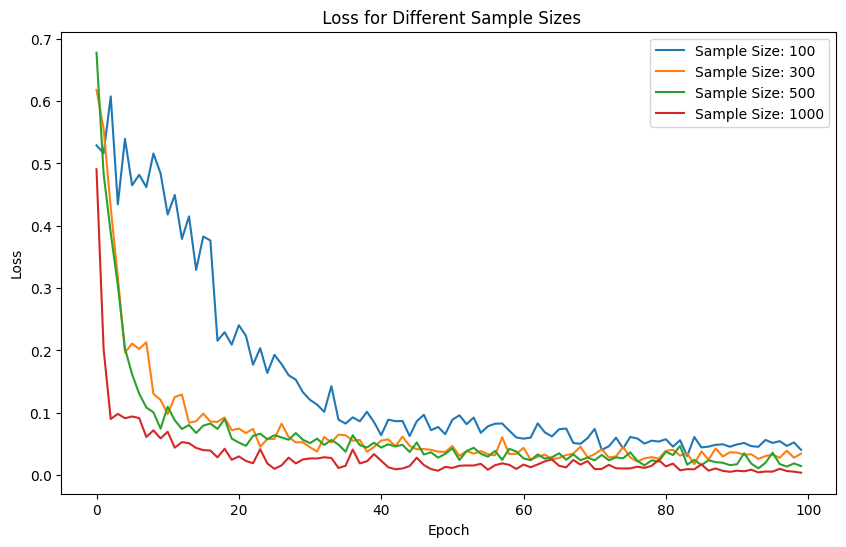

In [ ]:
#Train model with different data size
data_size = [100,300,500,1000]
num_epochs = 100

input_size=2
bottleneck_size=1
hidden_size=100
layers=5
Loss = []
for size in data_size:
    model = autoencoder(input_size,bottleneck_size,hidden_size,layers)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    training_set = torch.FloatTensor(X[:size,:])
    dataset = TensorDataset(training_set, training_set)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

    Loss_epoch = []
    for epoch in range(num_epochs):
      for data in data_loader:
          inputs,_ = data


          _,outputs = model(inputs)
          loss = criterion(outputs, inputs)


          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      Loss_epoch.append(loss.item())
      torch.save(model.state_dict(),'model'+str(size) +'-'+ str(epoch+1) +'.pth')

    Loss.append(Loss_epoch)


# Plot
plt.figure(figsize=(10, 6))
for i, size in enumerate(data_size):
    plt.plot(range(num_epochs), Loss[i], label=f"Sample Size: {size}")

plt.title(' Loss for Different Sample Sizes')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



#Comment
As expected, the loss will decrease when the size of training set increases.

Then we visualize the reconstruction in different epochs.

In [ ]:
#visualization

def visualization(epoch):
  loaded_epoch = epoch
  fig, axs = plt.subplots(2, 2,squeeze=False)
  for i, ax in enumerate(axs.flat):

      ax.scatter(X[0:data_size[i],0],X[0:data_size[i],1],label='Original Data', alpha=0.5)
      #Load parameters of autoencoder model
      loaded_state_dict = torch.load('model' +str(data_size[i]) +'-'+ str(loaded_epoch) +'.pth')
      model.load_state_dict(loaded_state_dict)
      training_set = torch.FloatTensor(X[0:data_size[i],:])
      #Reconstruction
      with torch.no_grad():
        code,reconstructed_data = model(training_set)
      ax.scatter(reconstructed_data[:,0],reconstructed_data[:,1], label='Reconstructed Data', alpha=0.5)

      ax.legend()
      ax.set_title('Data Set Size='+str(data_size[i]))


  plt.subplots_adjust(left=-0.2, right=1.2, top=1.3, bottom=0, wspace=0.2, hspace=0.4)
  fig.suptitle('Epoch='+str(loaded_epoch), y=1.5,fontsize=30)

  plt.show()



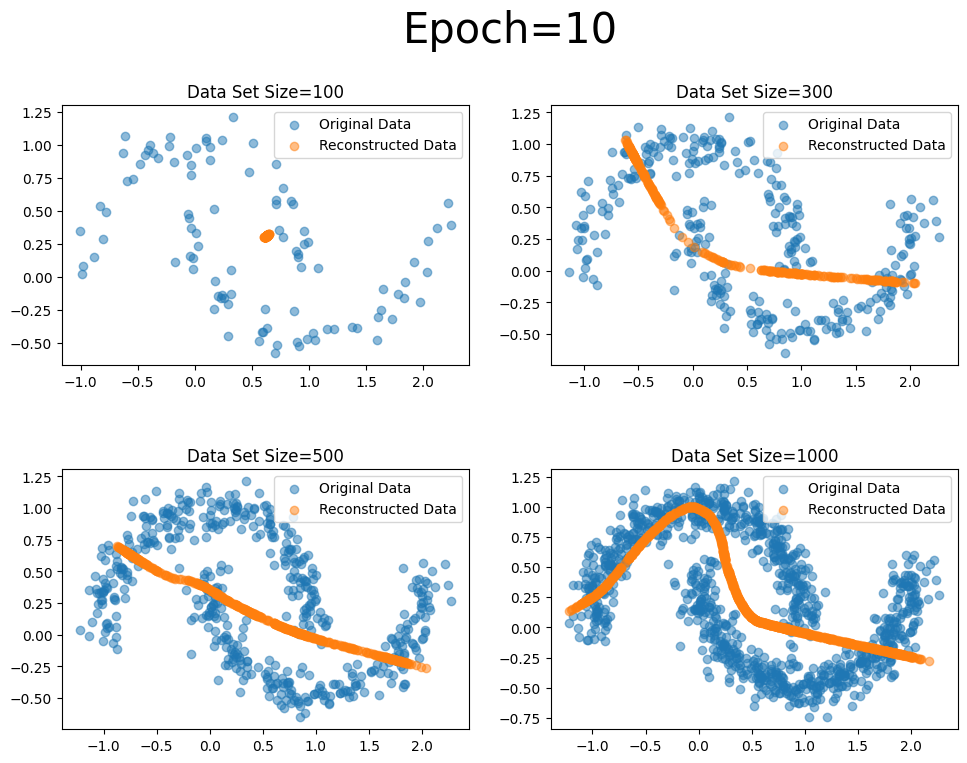

In [ ]:
visualization(10)

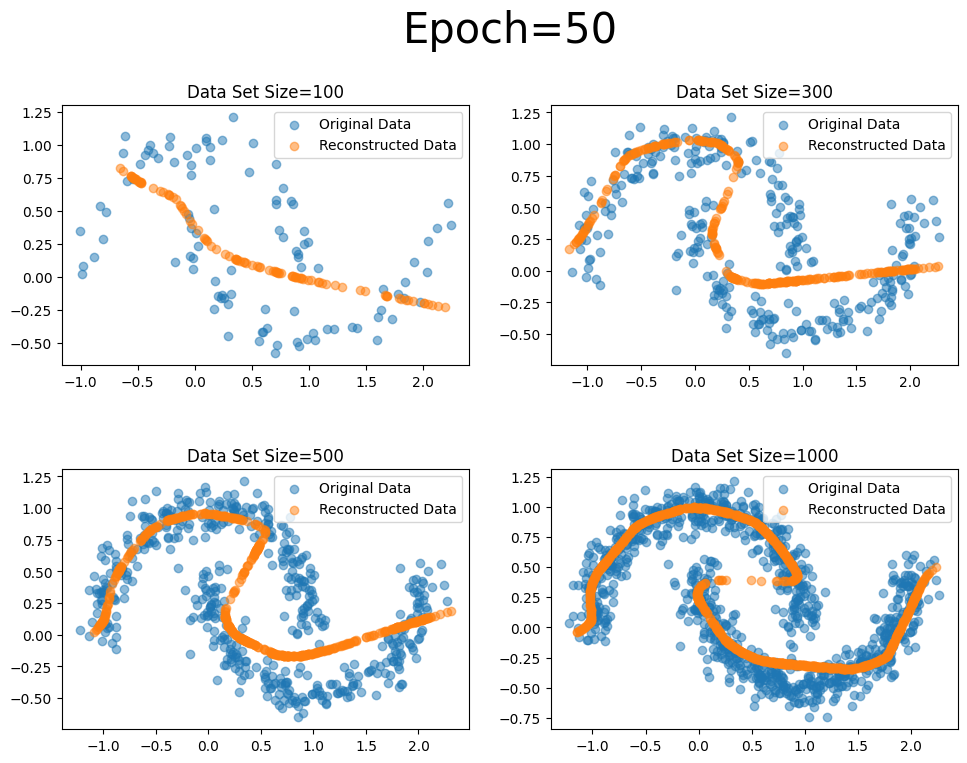

In [ ]:
visualization(50)

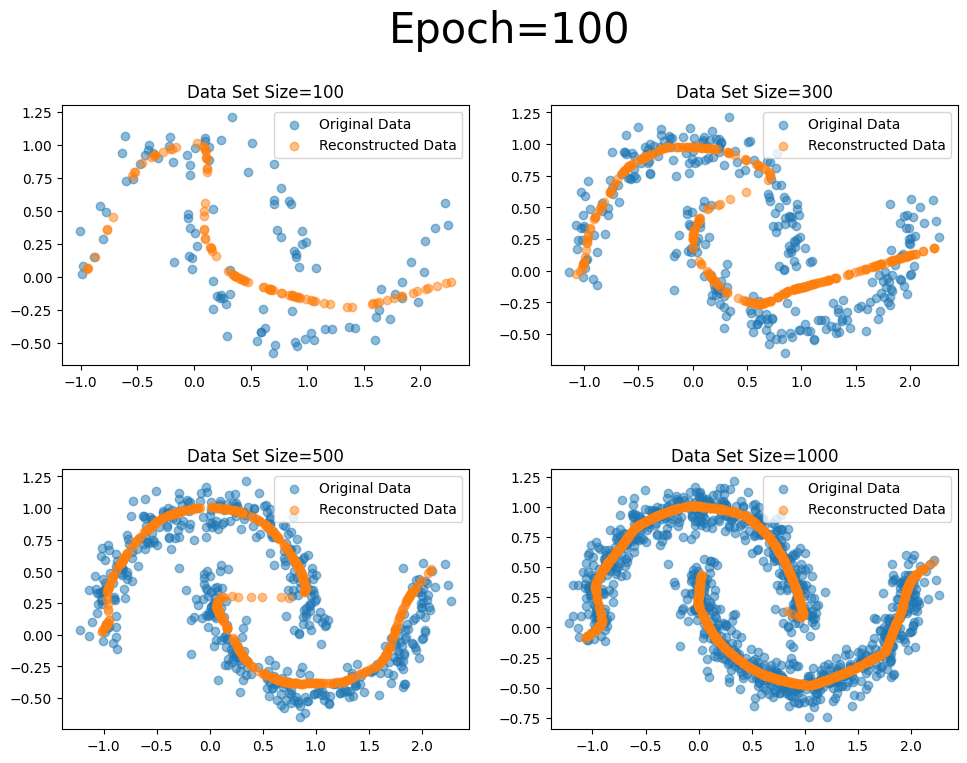

In [ ]:
visualization(100)

 <div style="color: green; font-weight:
bold">Comment</div>
Here we investigate the effect of hyperparameter data size, while the worked example shows the effect of batch size. They also train the model with a lager data set, which shows  the loss coverge faster just like our result.

#Comment:
With a small data set (size=100), this model still can't learn the structure of data after 100 epochs.When we increases data set to 1000, it can reconstruct very well, and can even capture basic structure of the data in only 10 epochs. So the size of training data matters a lot as expected.


#1.2 For the best hyperparameter settings you found, investigate how much the reconstruction varies when you repeat training with the same or diffeerent datasets. Comment on your observations.

In [ ]:
num_epochs=100
input_size=2
bottleneck_size=1
hidden_size=100
layers=5
data_list=[]
reconstructed_list=[]

for i in range(4):
    X, _ = make_moons(n_samples=1000, noise=0.1)
    data_list.append(X)
    X = torch.FloatTensor(X)
    dataset = TensorDataset(X, X)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=True)


    for epoch in range(num_epochs):
      for data in data_loader:
          inputs,_ = data


          _,outputs = model(inputs)
          loss = criterion(outputs, inputs)


          optimizer.zero_grad()
          loss.backward()
          optimizer.step()



    #Reconstruction
    with torch.no_grad():
      _,reconstructed_data = model(X)
    reconstructed_list.append(reconstructed_data)


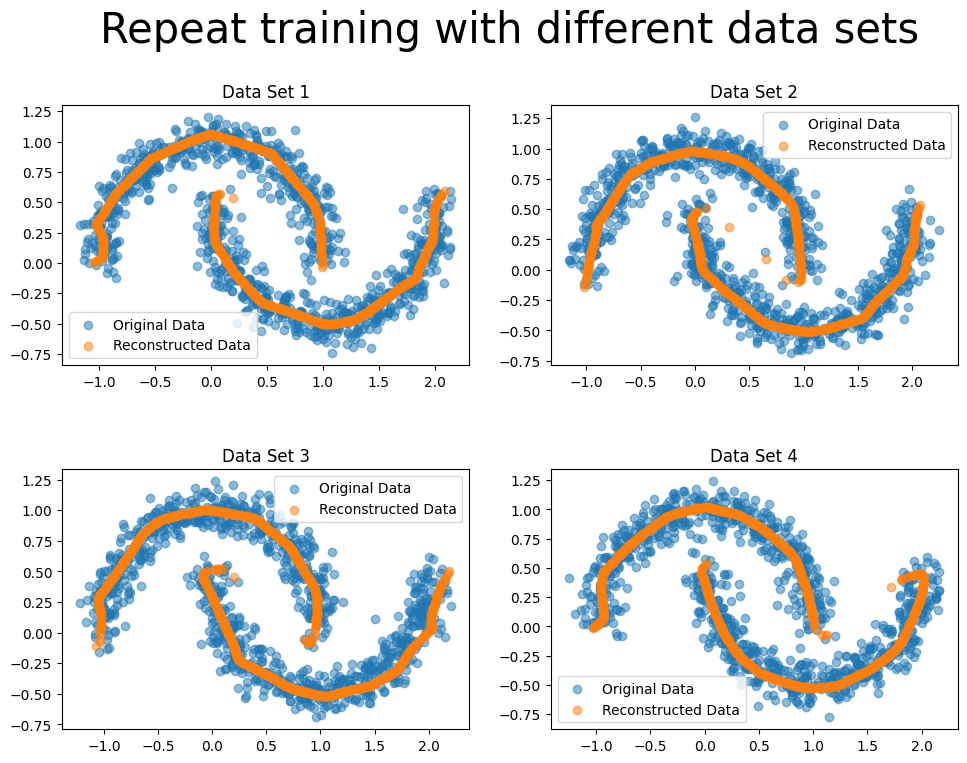

In [ ]:
fig, axs = plt.subplots(2, 2,squeeze=False)
for i, ax in enumerate(axs.flat):

    ax.scatter(data_list[i][:,0],data_list[i][:,1],label='Original Data', alpha=0.5)

    ax.scatter(reconstructed_list[i][:,0],reconstructed_list[i][:,1], label='Reconstructed Data', alpha=0.5)

    ax.legend()
    ax.set_title('Data Set '+str(i+1))


plt.subplots_adjust(left=-0.2, right=1.2, top=1.3, bottom=0, wspace=0.2, hspace=0.4)
fig.suptitle('Repeat training with different data sets', y=1.5,fontsize=30)

plt.show()

 <div style="color: green; font-weight:
bold">Comment</div>
In the worked example, they plot in every loop, while we train models with different data set first and storage training data together with reconstructed data in list, and then plot together. Compared to the example, our method takes up more memory.

#Comment
With the hyperparameters we choose, we can see the model is robust.

#1.3 Create and visualize a histogram of the code distribution. Fit a Gaussian mixture model to the code distribution and use it to sample synthetic data. Comment on the quality of the generated data.


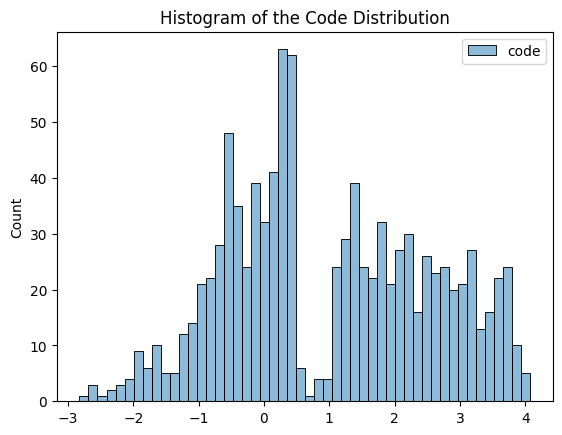

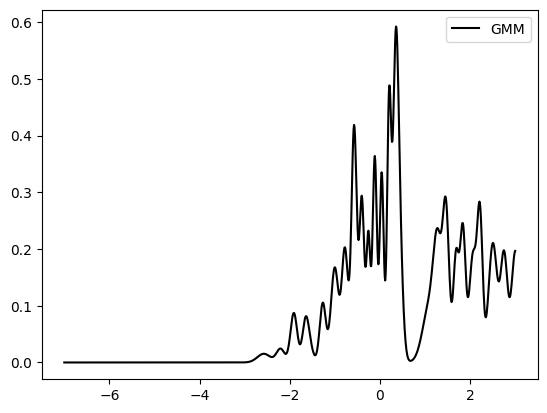

In [ ]:
#1.3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
import seaborn as sns

X = torch.FloatTensor(data_list[3])
with torch.no_grad():

  code,reconstructed_data = model(X)

#Use GMM to fit code
n_components=30
gmm=GaussianMixture( n_components,random_state=42)
gmm.fit(code)


x = np.linspace(-7, 3, 1000)
logprob = gmm.score_samples(x.reshape(-1, 1))
responsibilities = gmm.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]


#Plot histogram
sns.histplot(code, bins=50, label='code')
plt.xlim=(-7,3)
plt.title('Histogram of the Code Distribution')
plt.legend()
plt.show()



plt.plot(x, pdf, '-k', label='GMM')
plt.xlim=(-7,3)
plt.legend()

plt.show()

 <div style="color: green; font-weight:
bold">Comment</div>
Our histogram of data distribution is very similar to the worked example. We even chose the same number of bins. And the code value also varies from -3 to 4, with a gap at 0. But the data set we used is different. Since we already storaged training data, so we just used it to encode.

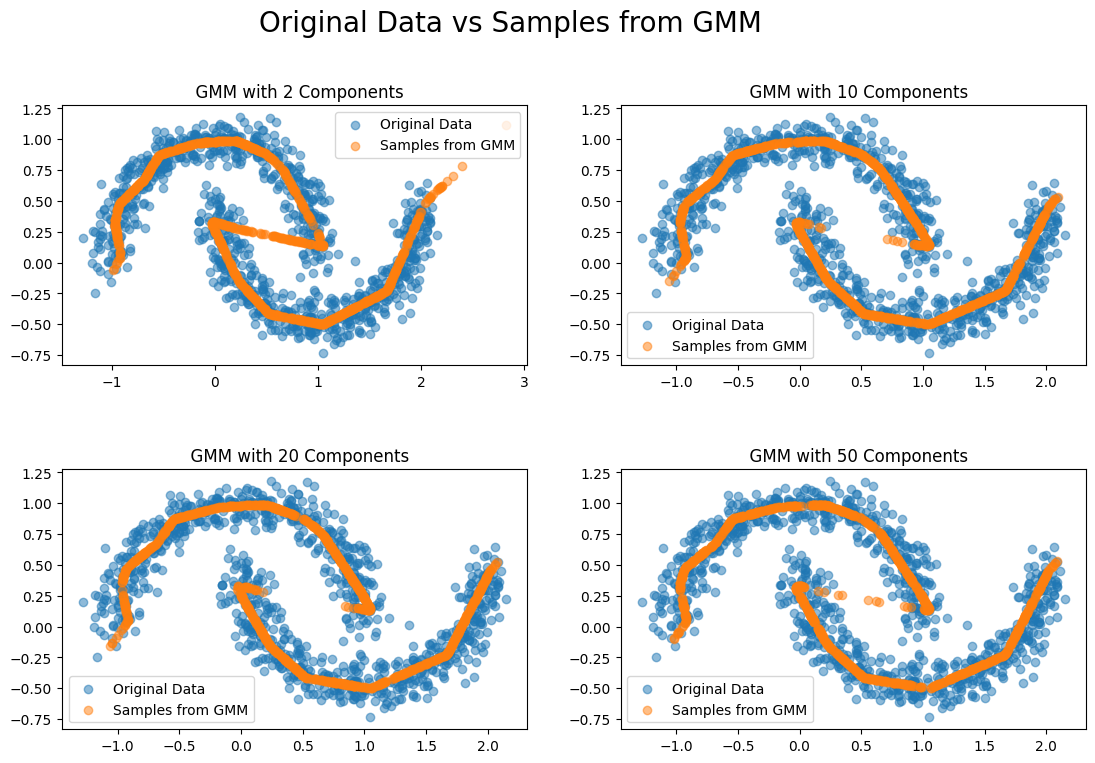

In [ ]:
#Visualizing the generated samples from GMM with different components
components_list=[2,10,20,50]
fig, axs = plt.subplots(2, 2,squeeze=False)

for i,ax in enumerate(axs.flat):
  #fitting GMM
  gmm=GaussianMixture( components_list[i],random_state=42)
  gmm.fit(code)


  #Generating samples from GMM
  n_samples=1000
  GMM_samples, _ = gmm.sample(n_samples)
  GMM_samples = torch.FloatTensor(GMM_samples)



  with torch.no_grad():
    #decoding code from samples generated from GMM
    reconstructed_data = model.decode_function(GMM_samples)

  ax.scatter(data_list[3][:, 0], data_list[-1][:, 1], label='Original Data', alpha=0.5)
  ax.scatter(reconstructed_data[:,0],reconstructed_data[:,1], label='Samples from GMM', alpha=0.5)
  ax.legend()
  ax.set_title('  GMM with '+str(components_list[i])+' Components')

plt.subplots_adjust(left=-0.2, right=1.4, top=1.3, bottom=0, wspace=0.2, hspace=0.4)
fig.suptitle('Original Data vs Samples from GMM', y=1.5,fontsize=20)

plt.show()





#Comment:
Since the data set is two moons, we naturally thought a GMM with 2 components would be the best. But it didn't turn out that way.20 is a better choice.

#1.4 Check if the autoencoder still works (without retraining!) on a test set at noise level 0.2.

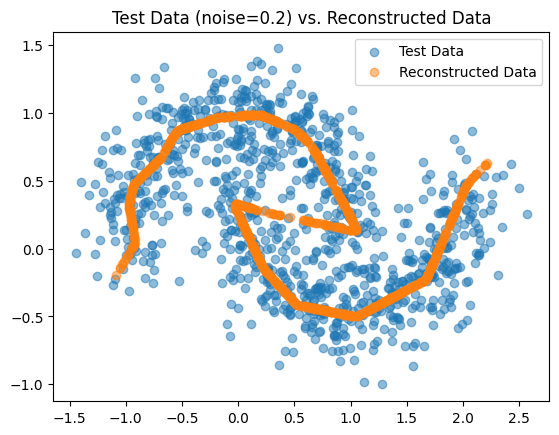

In [ ]:
#1.4
loaded_epoch = 100
n_samples=1000

Y, _ = make_moons(n_samples, noise=0.2, random_state=42)
test_data = torch.FloatTensor(Y)

with torch.no_grad():

  _,reconstructed_data = model(test_data)

plt.scatter(test_data[:, 0], test_data[:, 1], label='Test Data', alpha=0.5)


plt.scatter(reconstructed_data[:,0],reconstructed_data[:,1], label='Reconstructed Data', alpha=0.5)
plt.legend()
plt.title('Test Data (noise=0.2) vs. Reconstructed Data')
plt.show()

 <div style="color: green; font-weight:
bold">Comment</div>
The reconstructed data are quite similar to the example. Just we think the model didn't work well because it didn't seperate two moons well, while the worked example think finding the centerline is good enough.

#Comment:
It still works, but not good.

#1.5 Train an autoencoder with a training set at noise level 0.2 and comment on how the geometry of the reconstructed set changes.


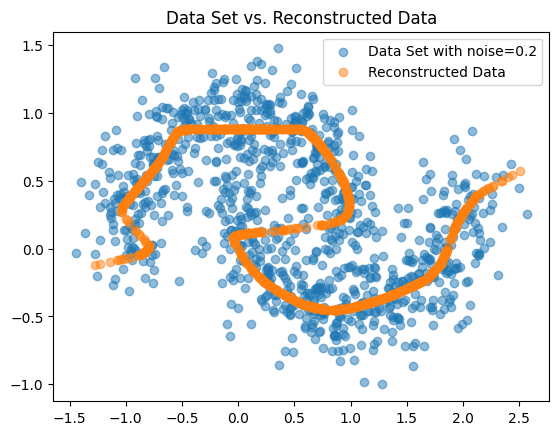

In [ ]:
Y, _ = make_moons(n_samples=1000, noise=0.2, random_state=42)


Y = torch.FloatTensor(Y)
dataset = TensorDataset(Y, Y)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)


input_size=2
bottleneck_size=1
hidden_size=100
layers=5
model = autoencoder(input_size,bottleneck_size,hidden_size,layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 100
for epoch in range(num_epochs):
    for data in data_loader:
        inputs, _ = data


        _,outputs = model(inputs)
        loss = criterion(outputs, inputs)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#reconstruction
with torch.no_grad():

  _,reconstructed_data = model(Y)

plt.scatter(Y[:, 0], Y[:, 1], label='Data Set with noise=0.2', alpha=0.5)
plt.scatter(reconstructed_data[:,0],reconstructed_data[:,1], label='Reconstructed Data', alpha=0.5)
plt.legend()
plt.title('Data Set vs. Reconstructed Data')
plt.show()


 <div style="color: green; font-weight:
bold">Comment</div>
The reconstructed data is different from the example, but both can illustrate the bad performance on this task.

#Comment:
It can still capture the basic structure of data, but the reconstructed set is not as smooth as former one (noise=0.1).

#Task 2

In [ ]:
#Redefine the MMD function we defined at last assignment with tensor form
def squared_distances(X, Y):
    """
    Compute the squared Euclidean distances between each pair of points in the two datasets X and Y.

    :param X: Array of shape (n_samples_X, n_features).
    :param Y: Array of shape (n_samples_Y, n_features).
    :return: Matrix of shape (n_samples_X, n_samples_Y) where each element represents the squared distance.
    """
    # Expand the squares of X and Y
    X_square = torch.sum(X**2, dim=1, keepdim=True)
    Y_square = torch.sum(Y**2, dim=1, keepdim=True)

    # Compute the squared distances
    squared_dist = X_square  -2 * torch.matmul(X, Y.t()) + Y_square.t()
    return squared_dist

def se_kernel_custom(X, Y, gamma=None):
    """
    Compute the Radial Basis Function (RBF) kernel (squared exponential) between each pair of points in X and Y.

    :param X: First dataset.
    :param Y: Second dataset.
    :param gamma: Gamma parameter for the RBF kernel. If None, it's set to 1/n_features.
    :return: RBF kernel matrix.
    """
    if gamma is None:
        gamma = 1.0 / X.shape[1]  # 1/n_features

    sq_dists = squared_distances(X, Y)
    return torch.exp(-gamma * sq_dists)

def compute_mmd(kernel_XX, kernel_YY, kernel_XY):
    """
    Compute the MMD value from the kernel matrices.
    :param kernel_XX: Kernel matrix among samples in X.
    :param kernel_YY: Kernel matrix among samples in Y.
    :param kernel_XY: Kernel matrix between samples in X and Y.
    :return: MMD value.
    """
    mmd_square = torch.mean(kernel_XX) + torch.mean(kernel_YY) - 2 * torch.mean(kernel_XY)
    return torch.sqrt(mmd_square)  # Return the square root to get MMD

In [ ]:
#Autoencoder model with different weights
import torch
from sklearn.datasets import make_moons
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
import os
import matplotlib.pyplot as plt
import numpy as np



n_samples = 1000

X, _ = make_moons(n_samples, noise=0.1, random_state=42)
X = torch.FloatTensor(X)

#Samples from a 2-dimensional standard normal
mean=[0,0]
covariance=[[1,0],[0,1]]
samples = np.random.multivariate_normal(mean, covariance, n_samples)
samples = torch.FloatTensor(samples)


dataset = TensorDataset(X, X)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

num_epochs = 100
input_size=2
bottleneck_size=2
hidden_size=100
layers=5
Loss = []
code_list=[]
reconstructed_list=[]

#hyperparameter: bandwidth
gamma=5.5
#weight of Loss_mse
weight_list=[0.2, 0.4, 0.6, 0.8]
for weight in weight_list:
    model = autoencoder(input_size,bottleneck_size,hidden_size,layers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    Loss_epoch = []
    for epoch in range(num_epochs):
      for data in data_loader:
          inputs, _ = data

          #Forward
          code,outputs = model(inputs)


          #Loss_mse
          loss_mse = criterion(outputs, inputs)
          #Loss_MMD
          kernel_XX_se = se_kernel_custom(code, code,gamma=gamma)
          kernel_YY_se = se_kernel_custom(samples, samples,gamma=gamma)
          kernel_XY_se = se_kernel_custom(code, samples,gamma=gamma)
          loss_MMD=compute_mmd(kernel_XX_se, kernel_YY_se, kernel_XY_se)

          #Loss_total
          loss=weight*loss_mse+(1-weight)*loss_MMD

          #Backward
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      Loss_epoch.append(loss.item())
    code,outputs=model(X)
    code_list.append(code)
    reconstructed_list.append(outputs)
    torch.save(model.state_dict(),'model'+str(weight) +'.pth')

    Loss.append(Loss_epoch)




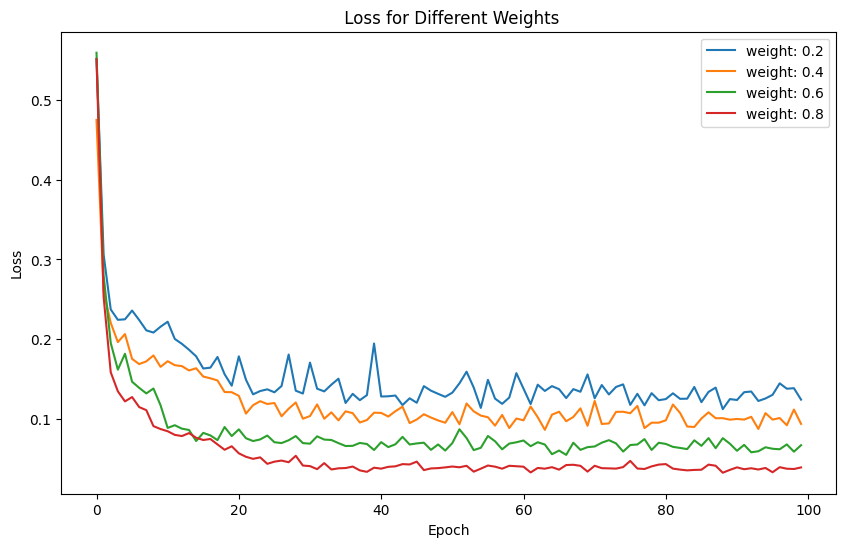

loss:  0.03924436494708061


In [ ]:
plt.figure(figsize=(10, 6))
for i, weight in enumerate(weight_list):
    plt.plot(range(num_epochs), Loss[i], label=f"weight: {weight}")

plt.title(' Loss for Different Weights')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print('loss: ',str(Loss[-1][-1]))

#Visualize the reconstructed vs. original data, and the code distribution. Check that the reconstruction error is much less than what you got with a bottleneck of size 1. Generate synthetic data by passing standard normal samples through the decoder and visualize their quality. Comment on your findings.


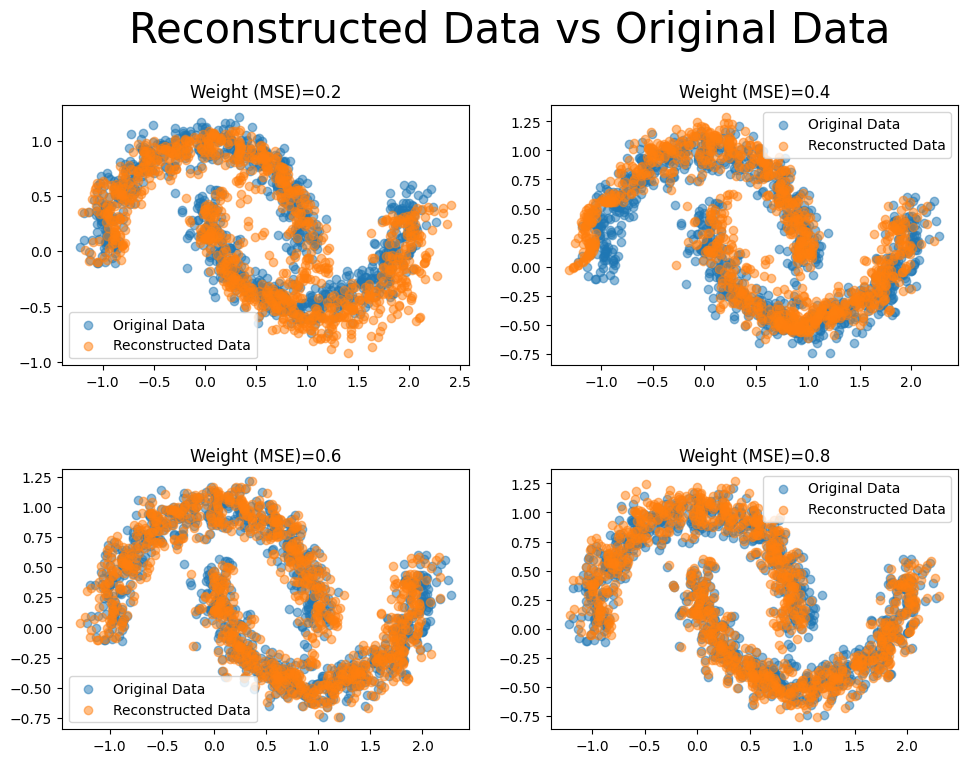

In [ ]:
fig, axs = plt.subplots(2, 2,squeeze=False)
for i, ax in enumerate(axs.flat):
    ax.scatter(X[:,0],X[:,1],label='Original Data', alpha=0.5)

    reconstructed_data=reconstructed_list[i].detach().numpy()

    ax.scatter(reconstructed_data[:,0],reconstructed_data[:,1], label='Reconstructed Data', alpha=0.5)

    ax.legend()
    ax.set_title('Weight (MSE)='+str(weight_list[i]))


plt.subplots_adjust(left=-0.2, right=1.2, top=1.3, bottom=0, wspace=0.2, hspace=0.4)
fig.suptitle('Reconstructed Data vs Original Data', y=1.5,fontsize=30)

plt.show()

#Comment
1.Here we set different weights of MSE loss. The MSE loss measures the difference between reconstructed and original data while MMD loss measures the difference between code distribution and a 2D normal distribution, so as expected,  the reconstruction will be better when the weight of MSE loss increases.

2.Compared to the bottleneck=1, this model is much better. The reconstructed dataset is almost fully overlapped with the original dataset, that's because  bottleneck=1 can only reconstruct data in one dimension while bottleneck=2 can reconstruct in two dimension.

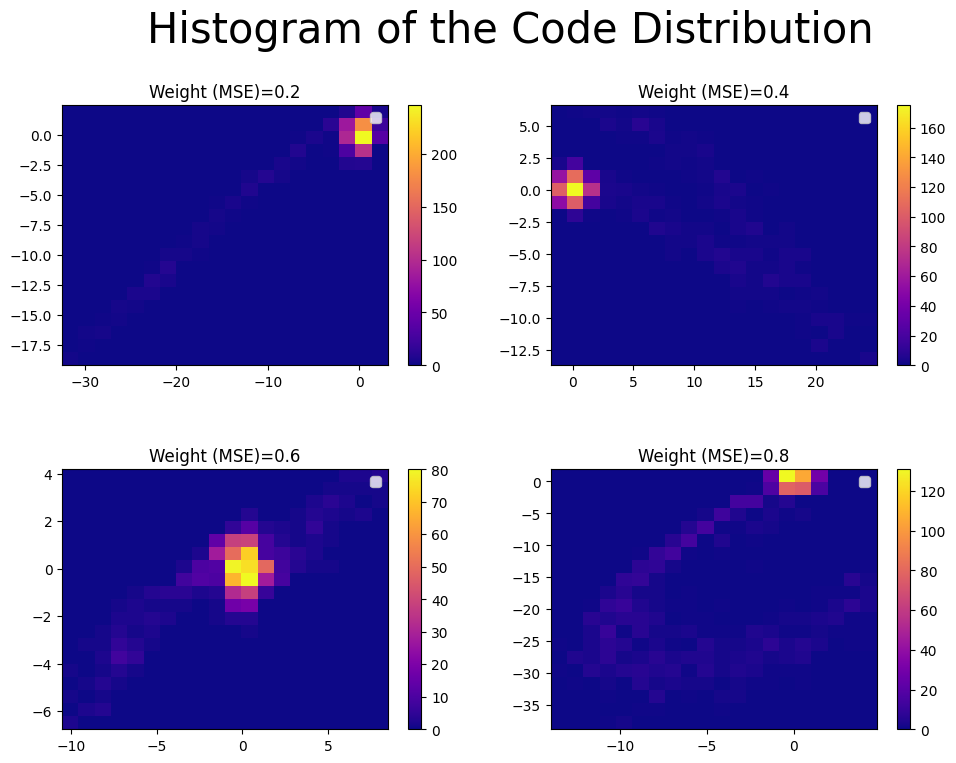

In [ ]:
fig, axs = plt.subplots(2, 2,squeeze=False)
for i, ax in enumerate(axs.flat):


    code=code_list[i].detach().numpy()

    hist=ax.hist2d(x=code[:,0], y=code[:,1], bins=20, cmap='plasma')
    fig.colorbar(hist[3], ax=ax)
    ax.legend()
    ax.set_title('Weight (MSE)='+str(weight_list[i]))

plt.subplots_adjust(left=-0.2, right=1.2, top=1.3, bottom=0, wspace=0.2, hspace=0.4)
fig.suptitle('Histogram of the Code Distribution', y=1.5,fontsize=30)

plt.show()

#Comment:
According to the histogram of code distribution,we can see that when the weight are 0.4 and 0.6, the distribution are more similar to the 2D standard normal distribution. So we can expect the reconstruction will be better with these two weight.

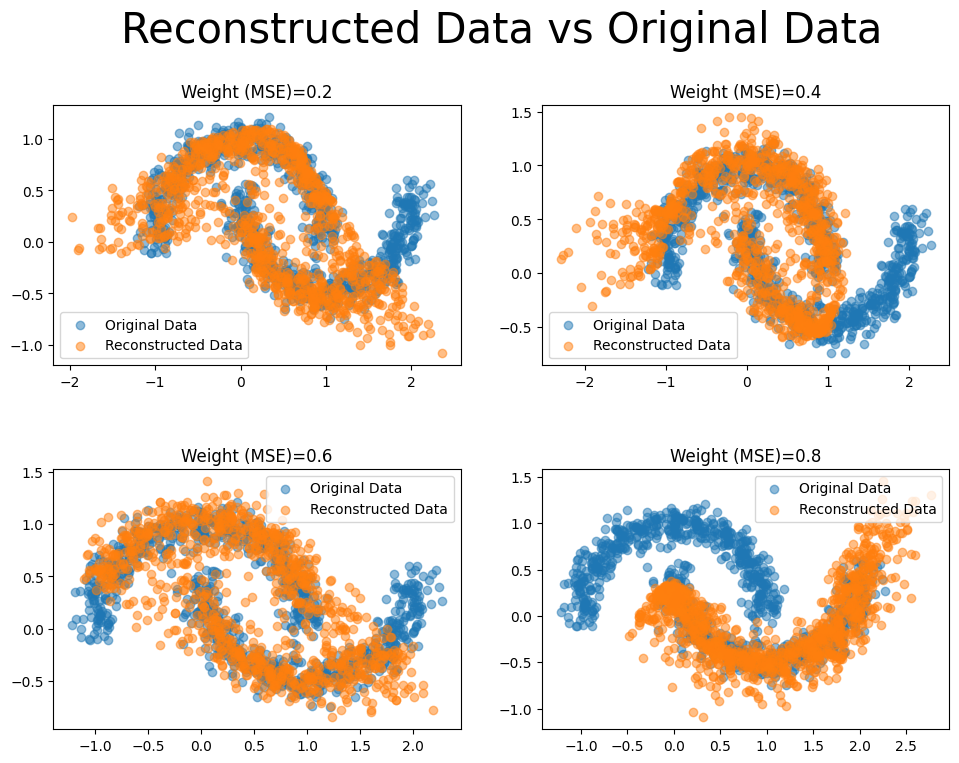

In [ ]:
fig, axs = plt.subplots(2, 2,squeeze=False)
for i, ax in enumerate(axs.flat):
    loaded_state_dict = torch.load('model' +str(weight_list[i]) +'.pth')
    model.load_state_dict(loaded_state_dict)
    reconstructed_data = model.decode_function(samples).detach().numpy()

    ax.scatter(X[:,0],X[:,1],label='Original Data', alpha=0.5)
    ax.scatter(reconstructed_data[:,0],reconstructed_data[:,1], label='Reconstructed Data', alpha=0.5)

    ax.legend()
    ax.set_title('Weight (MSE)='+str(weight_list[i]))


plt.subplots_adjust(left=-0.2, right=1.2, top=1.3, bottom=0, wspace=0.2, hspace=0.4)
fig.suptitle('Reconstructed Data vs Original Data', y=1.5,fontsize=30)

plt.show()


 <div style="color: green; font-weight:
bold">Comment</div>

Our model and structure of task 2 are different from the example.

1. We didn't use a Resnet.

2. Our loss function is loss=$ \lambda$*mse+ (1-$ \lambda $) *mmd, while it's loss=mse+ $ \lambda $ *mmd in worked example. We think ours is better, because the sum weights of mse and mmd is 1. And they chose $\lambda=1$ in all tasks, which equals to $\lambda=0.5$ in our case. 

3. Our code distribution and reconstruction is worse than the example. The main reason is that Resnet performs better on this task. Even we have chosen many weights and bandwidths (didn't show the details), the result is not good as we expected.


#Comment
1.When the weight is too small, the code will focus to fit the normal distribution and ignore the reconstruction accuracy. When the weight is too big, the code distribution will be far from normal distribution, so samples from normal distribution can't represent the code, which will cause great difference in reconstruction.

2.The bandwidth of kernal is also important. After many experiments we chose 5.5 as the bandwidth. When the value is smaller than 1 or bigger than 10, the reocnstruction will be quite bad.

Task 3

In [ ]:
import torch
import numpy as np
import pandas as pd
from torch import nn
import torch.nn.functional as F
from sklearn.datasets import make_moons, load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
from ray import tune
import ray
from ray import train, tune
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
import copy
import threading
from  sklearn.mixture import GaussianMixture as GMM
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

<div style="color: green; font-weight:
bold">
The autoencoder was implemented twice, so we have code duplication.
This implementation is almost identical to the provided solution.
However, our implementation is slightly different in architecture, this implementation lacks 1 ReLu layer, after the input layer.
This is a bug that should be fixed.
Also the initialization of the hidden_layer lists in the provided solution is probably a bit faster.
This implementation has the train_autoencoder function as a method of the class.
We don't have batch learning, so this is probably why the worked example can reach lower losses.
This makes no big difference in this context.
We also have a method implemented for calculating the loss.
This makes calculating losses more handy.
</div>

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super().__init__()
        self.input_size = input_size
        self.bottleneck_size = bottleneck_size
        self.hidden_size = hidden_size
        self.layers = layers
        self.hidden_layers_encoder = []
        self.hidden_layers_decoder = []



        self.input_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, input_size)
        self.bottleneck_layer = nn.Linear(bottleneck_size, bottleneck_size)

        self.hidden_layers_decoder.append(nn.Linear(bottleneck_size, hidden_size))

        for i in range(layers -1):
            self.hidden_layers_encoder.append(nn.Linear(hidden_size, hidden_size))
            self.hidden_layers_encoder.append(nn.ReLU())
            self.hidden_layers_decoder.append(nn.Linear(hidden_size, hidden_size))
            self.hidden_layers_decoder.append(nn.ReLU())

        self.hidden_layers_encoder.append(nn.Linear(hidden_size, bottleneck_size))

        self.encoder = nn.Sequential(self.input_layer,
                                   *self.hidden_layers_encoder,
                                   self.bottleneck_layer)

        self.decoder = nn.Sequential(*self.hidden_layers_decoder,
                                   self.output_layer)

        self.model = nn.Sequential(self.encoder, self.decoder)



    def encode(self, x):
        return self.encoder(x)


    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        return self.decode(self.encode(x))

    def calculate_loss(self, X):
        error_type = nn.MSELoss()
        reconstructed = self.forward(X)
        loss = error_type(reconstructed, X)
        return loss

    def train_autoencoder(self, X_train, ts_size, epochs, lr=.01):
            indices = torch.randperm(len(X_train))[:ts_size]
            X_train = X_train[indices]
            error_type = nn.MSELoss()
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
            losses = []
            for epoch in range(epochs):
                loss = self.calculate_loss(X_train)
                losses.append(loss)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


            return self, losses




<div style="color: green; font-weight:
bold">
This function handles the import of the datasets.
The function accidentally got copied, this is not really bad but one copy could have been deleted to make the notebook smaller.
Other than that we don't use the random_state in the train test split here, so the dataset will not be the same.
This makes our results less reproducible.
We can also add noise to the digits.
Here is no standard scalar implemented.
</div>

In [ ]:
def import_data(noise=0, random_state=1, shuffle=True, n_test=0.5, name="moons", n_samples = 2000):
    if name == "moons":
        data, _ = make_moons(noise=noise, random_state=random_state, shuffle=shuffle, n_samples=n_samples)
        X_train, X_test= train_test_split(data, test_size=n_test, random_state=random_state)
        return torch.FloatTensor(X_train), torch.FloatTensor(X_test), None, None

    elif name == "digits":
        data, labels = load_digits(return_X_y = True)
        data = data.reshape((len(data), -1))
        noise =  np.random.normal(0, noise * data.max(), data.shape)
        X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=n_test, random_state=random_state)
        return torch.FloatTensor(X_train), torch.FloatTensor(X_test), torch.FloatTensor(Y_train), torch.FloatTensor(Y_test)


In [ ]:
def import_data(noise=0, random_state=1, shuffle=True, n_test=0.5, name="moons", n_samples = 2000):
    if name == "moons":
        data, _ = make_moons(noise=noise, random_state=random_state, shuffle=shuffle, n_samples=n_samples)
        X_train, X_test= train_test_split(data, test_size=n_test, random_state=random_state)
        return torch.FloatTensor(X_train), torch.FloatTensor(X_test), None, None

    elif name == "digits":
        data, labels = load_digits(return_X_y = True)
        data = data.reshape((len(data), -1))
        noise =  np.random.normal(0, noise * data.max(), data.shape)
        X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=n_test, random_state=random_state)
        return torch.FloatTensor(X_train), torch.FloatTensor(X_test), torch.FloatTensor(Y_train), torch.FloatTensor(Y_test)

In [ ]:
X_train, X_test, Y_train, Y_test = import_data(noise=0.1, n_test=0.5,  name="digits")

<div style="color: green; font-weight:
bold">
There is no equivalent function to this in the worked example. However we calculate the loss here, without the according method of the autoencoder class.
So we have some code duplication again.
</div>

In [ ]:
def autoencoder_as_function_of_hyperparameters(config):
    auto, _ = AutoEncoder(config["input_size"], config["bottleneck_size"],
                    config["hidden_size"], config["layers"]).train_autoencoder(X_train,
                           config["ts_size"],
                           config["epochs"],
                           config["lr"])
    loss_func = nn.MSELoss()
    loss = float(loss_func(auto.forward(X_test), X_test).detach().numpy())
    metric = {"loss": loss }
    ray.train.report(metric
       )

<div style="color: green; font-weight:
bold">
We also do some automated hyperparameter tuning, so we don't have to find good parameters ourselves. This was not done in the worked example either, it was not explicitly asked for in the assignment tho.
</div>

In [ ]:

from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.ax import AxSearch
def opt(config):
    ax_search = AxSearch()
    algo = OptunaSearch()
    algo = ConcurrencyLimiter(algo, max_concurrent=4)

    tuner = tune.Tuner(
        autoencoder_as_function_of_hyperparameters,
        tune_config=tune.TuneConfig(
            scheduler=ASHAScheduler(),
            search_alg=algo,
            metric="loss",
            mode="min",
            num_samples=20,
        ),
        param_space=config,
    )

    result = tuner.fit()
    return result.get_best_result().config


2023-11-21 20:55:10,745	INFO tune.py:1045 -- Total run time: 30.20 seconds (28.25 seconds for the tuning loop).


<div style="color: green; font-weight:
bold">
The search space is based on an assumed range of architectures. In the worked example, the hidden size is 64, however in the assignment it was said that the hidden size should be bigger than the input size. 
</div>

In [ ]:
config={"input_size":  tune.choice([64]), "bottleneck_size":  tune.choice([8]),
        "hidden_size":  tune.choice([x for x in range(100, 600, 40)]),
        "layers":  tune.choice([x for x in range(1, 5)]),
        "ts_size":  tune.choice([x for x in range(100, 1500, 100)]),
        "epochs":  tune.choice([x for x in range(400, 600)]),
        "lr": tune.choice([0.01, 0.001])}

good_config = opt(config)

2023-11-21 13:20:32,944	INFO tune.py:1045 -- Total run time: 107.46 seconds (107.42 seconds for the tuning loop).


<div style="color: green; font-weight:
bold">
The task was to repeat task 1 for the digits data set. Hence the reconstruction error is plotted as a function of the hyperparameters. This is not done in the worked example.
</div>

The plot below shows the MSE reconstruction error vs the parameters. For hidden size, the size of the ts and the number of epochs, the error seems to stagnate. So increasing them after some point wont change anything. Some local optima can be spotted for the number of layers and the learning rate. Increasing the bottle neck size decreases the error drasticly.  

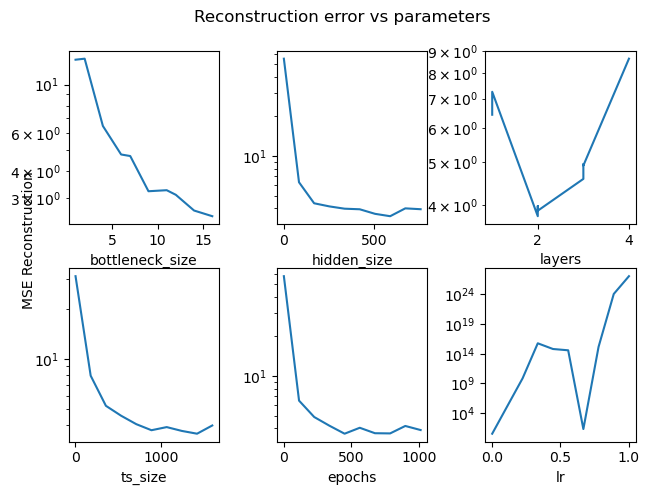

In [ ]:
generate_plots()

The plot below shows the averaged error vs the bottleneck size. The error decays and will propably stagnate after dim(z) > 20.

<div style="color: green; font-weight:
bold">
The assignment asked for a plot of the reconstruction error vs the bottleneck size. This was also not done in the worked example.
Here the print statement to track progress is quite bad since it decreases the performance and makes the notebook less readable. 
Also the axis labels are wrong.
</div>

1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
7
7
7
8
8
8
8
9
9
8
8
8
8
9
9
10
10
9
9
9
9
9
9
10
10
11
11
10
10
10
10
10
11
10
11
12
12
11
11
11
12
11
11
11
12
13
13
12
12
12
13
13
12
12
12
14
14
13
13
13
14
14
13
13
13
15
15
14
14
14
15
15
16
16
14
14
14
15
15
16
16
15
17
17
15
15
15
16
16
17
17
18
18
16
16
16
16
17
17
19
19
18
18
17
17
17
17
18
18
19
19
18
18
18
18
19
19
19
19
19
19
(19,)


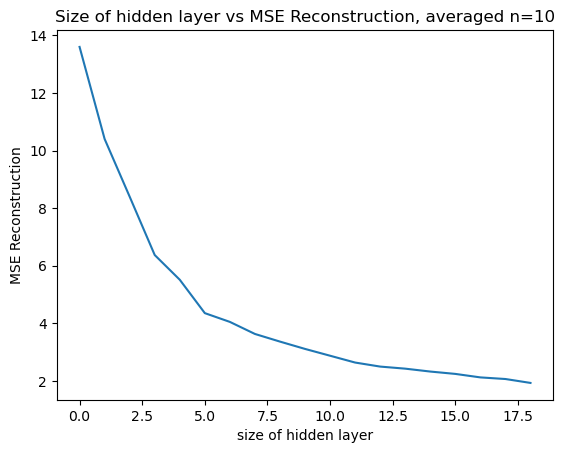

In [ ]:
losses = []
def plot_loss_vs_hidden_size():
    loss = []
    for i in range(1, 20):
        print(i)
        auto, _ =  AutoEncoder(good_config["input_size"], i,
                                    good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train,
                                           good_config["ts_size"],
                                           good_config["epochs"],
                                           good_config["lr"])
        loss.append(float(auto.calculate_loss(X_test).detach().numpy()))
    losses.append(np.array(loss))

n = 10
threads = []
for i in range(n):
    thread = threading.Thread(target=plot_loss_vs_hidden_size)
    thread.start()
    threads.append(thread)
[t.join() for t in threads]
plt.title(f"Size of hidden layer vs MSE Reconstruction, averaged n={n}")
plt.xlabel("size of hidden layer")
plt.ylabel("MSE Reconstruction")
loss = np.array([0 for x in range(len(losses[0]))])
print(loss.shape)
for l in losses:
    loss = np.add(loss, l)
loss = loss/n
plt.plot([x for x in range(len(loss))], loss)


<div style="color: green; font-weight:
bold">
The visualization of the reconstruction is done more extensive in the provided solution. There is also the difference plotted there. So the provided solution is better in this regard. The takeaway however is quite the same: the reconstruction gets better with larger bottleneck size.
</div>

The plot belows shows randomly selected digits from the data set and its reconstruction for different dim(z). It can be observed that with increasing dim(z), the reconstruction gets better. A simple explanation would be, that 2 dimensional codes are not sufficient to encode all the information per sample.

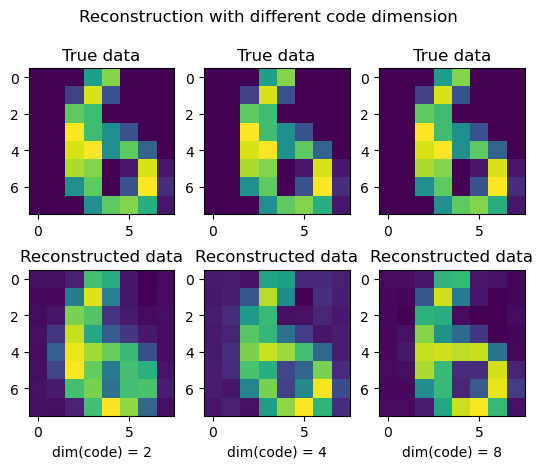

In [ ]:
fig, axs = plt.subplots(2, 3)
fig.suptitle(f"Reconstruction with different code dimension")

j = 0
x = np.random.choice([i for i in range(len(X_test))])
x = X_test[x]
for i in [2, 4, 8]:
    auto, _ =  AutoEncoder(good_config["input_size"], i,
                                    good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train,
                                           good_config["ts_size"],
                                           good_config["epochs"],
                                           good_config["lr"])



    axs[0, j].imshow(x.reshape(8,8))
    axs[0, j].set_title("True data")
    axs[1, j].imshow(auto.forward(x).detach().numpy().reshape(8, 8))
    axs[1, j].set_title("Reconstructed data")
    axs[1, j].set_xlabel(f"dim(code) = {i}")
    j += 1

<div style="color: green; font-weight:
bold">
There was no similar plot in the provided solution for this task.
</div>

The plot below shows, that the autoencoder does not yield the exact same results for the same parameters. Therefore there is always some variation in the results. This is due to random initialization of the weights and the random order and selection of the data set used for training.

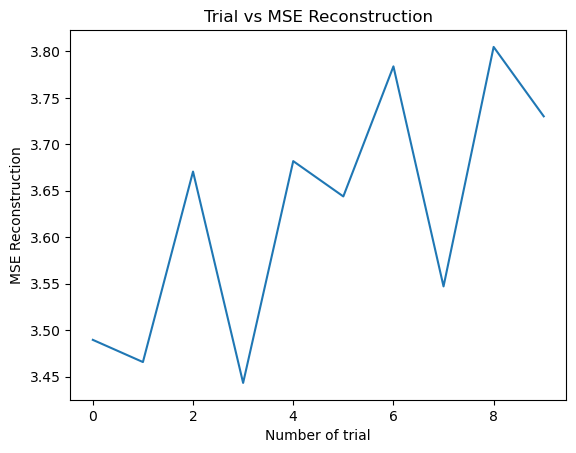

In [ ]:
n = 10
plt.title(f"Trial vs MSE Reconstruction")
plt.xlabel("Number of trial")
plt.ylabel("MSE Reconstruction")
loss = []
for i in range(n):
    auto, _ =  AutoEncoder(good_config["input_size"],good_config["bottleneck_size"] ,
                                    good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train,
                                           good_config["ts_size"],
                                           good_config["epochs"],
                                           good_config["lr"])
    loss.append(float(auto.calculate_loss(X_test).detach().numpy()))

plt.plot(loss)


<div style="color: green; font-weight:
bold">
The functions below generate encoded samples, fit GMMs to the samples in code space and plot the decoded synthetic data. The provided solution has a similar approach, however in our solution the BIC is used to do some crude hyper parameter optimization for the GMMs. This was not done in the provided solution. There the GMM has 10 components, which makes sense since we have 10 digits, so there must be up to 10 different classes. Our solution is slower than the provided solution because of this. Also the resulting number of components might not be 10.
</div>

In [ ]:
def get_z(X, auto=None, bs=None):
    if auto is None:
        auto, _ =  AutoEncoder(good_config["input_size"],(good_config["bottleneck_size"] if bs is None else bs),
                                        good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train,
                                               good_config["ts_size"],
                                               good_config["epochs"],
                                               good_config["lr"])
    return auto, auto.encode(X)

In [ ]:
def plot_synthetic_data(bs, k):
    if bs != 0:
        auto, Z_train = get_z(X_test, bs=bs)
        _, Z_test = get_z(X_train, auto=auto)

        Z_train = Z_test.detach().numpy()
        Z_test = Z_test.detach().numpy()
        scores = []
        for n in range(1, 50):
            scores.append(GMM(n_components = n).fit(Z_train).bic(Z_test))
        gmm = GMM(n_components= np.argmin(scores)).fit(Z_test)
        samples = torch.FloatTensor(gmm.sample(k**2)[0])
        synthetic_data = auto.decode(samples)
    else:
        synthetic_data = X_test
    fig, ax = plt.subplots(k,k)
    for i in range(k**2):
        ax.flatten()[i].imshow(synthetic_data[i].detach().numpy().reshape(8,8))

Here 4 by 4 codes get drawn from the gmm and reconstructed. First for dim(z) = 2, dim(z) = 4, dim(z) = 8 and 16 samples from the original data set for comparision. It can be observerd that with increasing code dimension, the synthetic numbers get more readable but also the background gets more noisy.

<div style="color: green; font-weight:
bold">
There is no measurement of entropy and accuracy in our solution. This means that we lack some insight. Also our plots don't have labels or titles. Hence the provided solution is better here.
</div>

C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

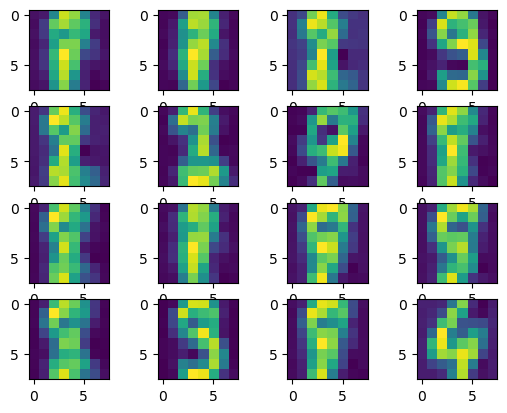

In [ ]:
plot_synthetic_data(2, 4)

C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

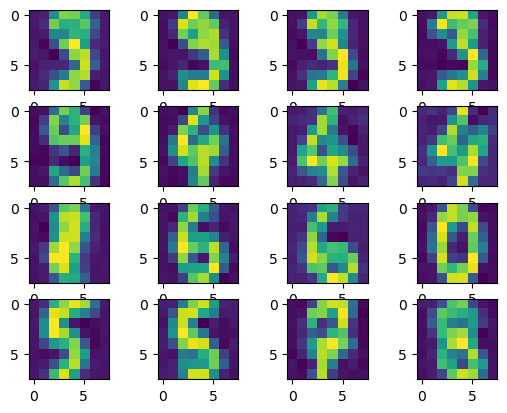

In [ ]:
plot_synthetic_data(4, 4)

C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

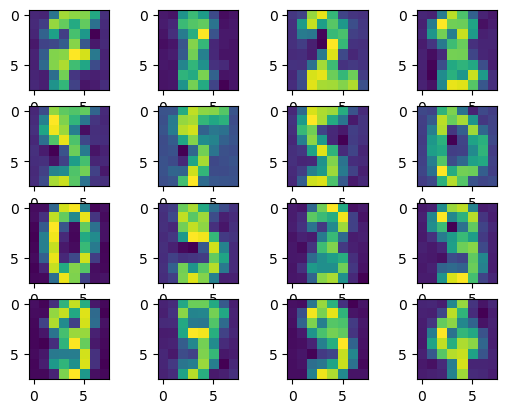

In [ ]:
plot_synthetic_data(8, 4)

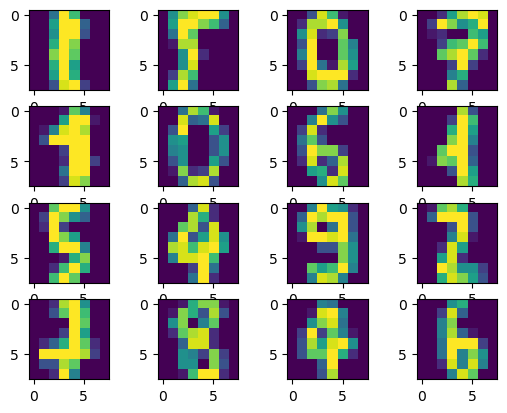

In [ ]:
plot_synthetic_data(0, 4)

The plot below shows the distribution of the codes for dim(z) = 2. It is observable that most of the digits overlap. Hence some digits are too similar to each other in code space. This shows that 2 dimensional codes are not enough to reliably seperate the digits.

<div style="color: green; font-weight:
bold">
The provided solution plots the distribution of data in code space. The assignment only asked for dim(code) = 2, the provided solution does it for bottleneck size 2, 4 and 8. In order to plot them, the data gets projected into a 2d space by pca. This is also done for bottleneck size = 2, so the results might be rotated in the provided solution. Other than that the approach is pretty much the same, so our solution is not too different from the provided one. The provided solution represents samples from the fitted GMMs the same way. This was not done by us, so we are missing some part here.
</div>

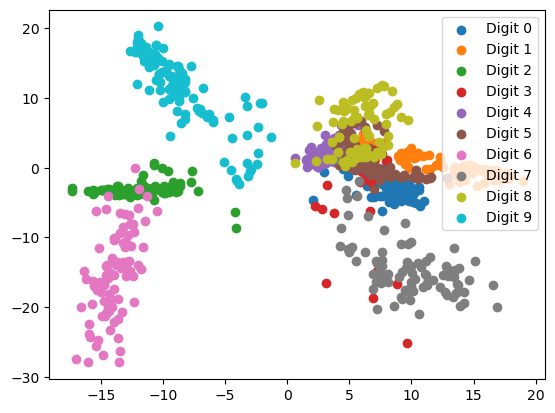

In [ ]:
for i in range(10):
    _, z = get_z(X_test[np.where(Y_test == i)], bs=2)
    z = z.detach().numpy()
    plt.scatter(z.T[0], z.T[1], label=f"Digit {i}")
plt.legend()

In [ ]:
def train_rfc(data, targets):
    p_grid = {"n_estimators":[100 * x for x in range(4)], "criterion" : ["gini", "entropy", "log_loss"],
                             "max_features": ["sqrt", "log2", None]}
    rfc = HalvingGridSearchCV(RFC(), p_grid, refit=True, verbose=1, cv=3).fit(data, targets)
    return rfc.best_estimator_


In [ ]:
rfc = train_rfc(X_train, Y_train)

n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 60
max_resources_: 898
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 36
n_resources: 60
Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
27 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Florian\anaconda3\Lib\sit

----------
iter: 1
n_candidates: 12
n_resources: 180
Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [       nan 0.69210526 0.65877193 0.6754386         nan 0.69298246
 0.69385965 0.67631579        nan 0.57017544 0.62368421 0.60526316
        nan 0.70964912 0.6745614  0.69298246        nan 0.71052632
 0.67631579 0.67631579        nan 0.67368421 0.64035088 0.69210526
        nan 0.72894737 0.70964912 0.63947368        nan 0.70964912
 0.69298246 0.71052632        nan 0.63947368 0.65789474 0.63859649
 0.89312618 0.89303202 0.90433145 0.89868173 0.88766478 0.89303202
 0.8873823  0.89877589 0.89312618 0.88747646 0.87052731 0.88182674]
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the train scores are non-finite: [nan  1.  1.  1. nan  1.  1.  1. nan  1.  1.  1. nan  1.  1.  1. nan  1.
  1.  1. nan  1.  1.  1. nan  1.  1.  1. nan  1.  1.  1. nan  1.  1.  1.
  1.  1. 

----------
iter: 2
n_candidates: 4
n_resources: 540
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [       nan 0.69210526 0.65877193 0.6754386         nan 0.69298246
 0.69385965 0.67631579        nan 0.57017544 0.62368421 0.60526316
        nan 0.70964912 0.6745614  0.69298246        nan 0.71052632
 0.67631579 0.67631579        nan 0.67368421 0.64035088 0.69210526
        nan 0.72894737 0.70964912 0.63947368        nan 0.70964912
 0.69298246 0.71052632        nan 0.63947368 0.65789474 0.63859649
 0.89312618 0.89303202 0.90433145 0.89868173 0.88766478 0.89303202
 0.8873823  0.89877589 0.89312618 0.88747646 0.87052731 0.88182674
 0.95353818 0.94795158 0.95542106 0.95912477]
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the train scores are non-finite: [nan  1.  1.  1. nan  1.  1.  1. nan  1.  1.  1. nan  1.  1.  1. nan  1.
  1.  1. nan  1.  1.  1. nan  1.  1. 

In [ ]:
rfc.score(X_test, Y_test)

0.9699666295884316

In [ ]:
def reconstruction_quality():
    fig, ax = plt.subplots(1, 3)
    j = 0
    for i in [2,4,8]:
        auto, _ =  AutoEncoder(good_config["input_size"],i,
                                            good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train,
                                                   good_config["ts_size"],
                                                   good_config["epochs"],
                                                   good_config["lr"])
        reconstructed = auto.forward(X_test).detach().numpy()
        predictions = rfc.predict(reconstructed)
        diff = Y_test - predictions
        correct = len(np.where(abs(diff) <= 1E-8)[0])
        false = len(Y_test) - correct
        ax[j].bar(["right", "wrong"], [correct, false])
        j += 1



<div style="color: green; font-weight:
bold">
As already mentioned, the evaluation of reconstruction quality was not done by comparing entropy. Our approach is different (explained below) and less sophisticated. The takeaway is quite different. Our results show that bottleneck size 8 is best here, in the provided solution the best bottleneck size is actually 4. The provided solution should be better since it does not consider the predicted classes but the confidence of the prediction.
</div>

To get an idea how well the autoencoder behaves, some data gets reconstructed bz the autoencoder. Then a random forest classifier classifies the reconstructed data. Those classifications get compared to the labels of the original data. If the label and the RFCs prediction match, the reconstruction is deemd successfull. Otherwhise the reconstruction is flawed. The histogram below shows the results of this procedure for different code dimentions (2, 4, 8) in this order. The reconstruction quality gets better with increasing code dimension. This is also observable on previous plots.

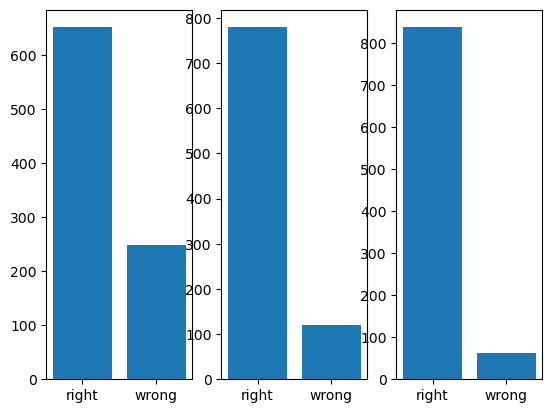

In [ ]:
reconstruction_quality()